# setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, Concatenate, Add
from tensorflow.keras.optimizers import SGD
import numpy as np
import os
import glob
import cv2 as cv
import gc
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
 actual_resume_Brandon_Hernandez_en.pdf		 Gastos.gsheet
 Anglo						'Geisel Library'
'B & B ❤️✨'					 GRE_REU-ENLACE_student.pptx
 Boletomovil_Compra_I6TDJEACXOF9GHR4_36448.pdf	 Gu_a_Introductoria_R.pdf
 BoletosPanteon.pdf				 ITAM
'Brandon Hernandez carta UCSD.gdoc'		'Libros y Recursos'
 CACARO						 MBZUAI
'Colab Notebooks'				 Portada.gdoc
 d73b1db9-9844-4fa9-95c2-65ebb1b0b3c6.pdf	'Presentacion TESIS.pptx'
 deep_learning					'Task 1 Brandon.gdoc'
'Documentos personales'				'Task 1 - Brandon.gdoc'
 ENLACE						'Task 2 Brandon.gdoc'
 Finanzas					'TASK 2 Brandon.gdoc'
'Fotos grad'					 Trabajo
'Fotos grad 18 09 2021'				 Udemy


# Unzip images and refactor folders

In [ ]:
%cd /content/
!unzip /mydrive/deep_learning/preprocessed.zip
!unzip /mydrive/deep_learning/gaussian_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: gaussian_images/train/4252_train_blured.png  
  inflating: gaussian_images/train/10267_train_blured.png  
  inflating: gaussian_images/train/18589_train_blured.png  
  inflating: gaussian_images/train/10259_train_blured.png  
  inflating: gaussian_images/train/13413_train_blured.png  
  inflating: gaussian_images/train/7426_train_blured.png  
  inflating: gaussian_images/train/15011_train_blured.png  
  inflating: gaussian_images/train/1024_train_blured.png  
  inflating: gaussian_images/train/21576_train_blured.png  
  inflating: gaussian_images/train/8855_train_blured.png  
  inflating: gaussian_images/train/19815_train_blured.png  
  inflating: gaussian_images/train/24503_train_blured.png  
  inflating: gaussian_images/train/4051_train_blured.png  
  inflating: gaussian_images/train/521_train_blured.png  
  inflating: gaussian_images/train/10064_train_blured.png  
  inflating: gaussian_images/train/2453_train_blured.png

In [ ]:
!rm -r __MACOSX

In [ ]:
!mkdir data

In [ ]:
!mv preprocessed/ data/
!mv gaussian_images/ data/

In [ ]:
!cp /mydrive/deep_learning/preprocessed_train.txt data/
!cp /mydrive/deep_learning/preprocessed_valid.txt data/
!cp /mydrive/deep_learning/gaussian_train.txt data/
!cp /mydrive/deep_learning/gaussian_valid.txt data/

In [ ]:
base_path = os.path.join("/content", "data")

# get image's paths: x_train and x_valid

In [ ]:
x_train_file = os.path.join(base_path, "preprocessed_train.txt")
with open(x_train_file) as ptf:
  x_train = ptf.read().splitlines()
ptf.close()

In [ ]:
x_train[0]

'preprocessed/train/10000_train.png'

In [ ]:
x_valid_file = os.path.join(base_path, "preprocessed_valid.txt")
with open(x_valid_file) as pvf:
  x_valid = pvf.read().splitlines()
pvf.close()

In [ ]:
x_valid[0]

'preprocessed/valid/1000_valid.png'

## get image's paths: x_train_gaussian and x_valid_gaussian

In [ ]:
x_train_gaussian_file = os.path.join(base_path, "gaussian_train.txt")
with open(x_train_gaussian_file) as xgtf:
  x_gaussian_train = xgtf.read().splitlines()
xgtf.close()

In [ ]:
x_gaussian_train[0]

'gaussian_images/train/10000_train_blured.png'

In [ ]:
x_valid_gaussian_file = os.path.join(base_path, "gaussian_valid.txt")
with open(x_valid_gaussian_file) as xgvf:
  x_gaussian_valid = xgvf.read().splitlines()
xgvf.close()

In [ ]:
x_gaussian_valid[0]

'gaussian_images/valid/1000_valid_blured.png'

In [ ]:
print("Dimensiones para imagenes originales:", len(x_train), len(x_valid))
print("Dimensiones para imagenes gaussianas:", len(x_gaussian_train), len(x_gaussian_valid))

Dimensiones para imagenes originales: 25462 2121
Dimensiones para imagenes gaussianas: 25462 2121


# Limit to 15000 images of train and 500 of valid

In [ ]:
x_train = x_train[:15000]
x_valid = x_valid[:500]
x_gaussian_train = x_gaussian_train[:15000]
x_gaussian_valid = x_gaussian_valid[:500]

# Autoencoder

In [ ]:
gc.collect()

8

In [ ]:
OW, NW = 48, 48
OH, NH = 64, 64

In [ ]:
# Crear las listas para las imágenes originales y con ruido
original_images = []
noisy_images = []

# Leer las imágenes originales y con ruido
for or_img, ns_img in zip(x_train, x_gaussian_train):

    # Leer las imágenes en escala de grises
    original_image = cv.imread(os.path.join(base_path, or_img))
    noisy_image = cv.imread(os.path.join(base_path, ns_img))

    oh, ow, _ = original_image.shape
    nh, nw, _ = noisy_image.shape


    original_image = cv.resize(original_image, (OW, OH), interpolation = cv.INTER_AREA)
    noisy_image = cv.resize(noisy_image, (NW, NH), interpolation = cv.INTER_AREA)

    # Normalizar los valores de píxeles en el rango [0, 1]
    original_image = original_image.astype(np.float32) / 255.0
    noisy_image = noisy_image.astype(np.float32) / 255.0

    # Agregar las imágenes a las listas
    original_images.append(original_image)
    noisy_images.append(noisy_image)

# Asegurarse de que las imágenes tengan la forma adecuada
original_images = np.expand_dims(original_images, axis=-1)
noisy_images = np.expand_dims(noisy_images, axis=-1)

In [ ]:
original_images = np.squeeze(original_images)
noisy_images = np.squeeze(noisy_images)

In [ ]:
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [ ]:
# Definir la arquitectura del autoencoder
def build_autoencoder():
    # Encoder
    input_img = Input(shape=(64, 48, 3))
    h = BatchNormalization()(input_img)

    h = Conv2D(32, (3, 3), padding='same', activation='relu')(h)
    h = MaxPool2D((2, 2))(h)

    h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
    h = MaxPool2D((2, 2))(h)

    h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)

    encoded = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
    h = Conv2D(32, (3, 3), padding='same', activation='elu')(encoded)

    h = UpSampling2D((2, 2))(h)
    h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)
    h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)

    h = UpSampling2D((2, 2))(h)
    h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
    
    h = BatchNormalization()(h)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(h)

    # Autoencoder model
    autoencoder = Model(input_img, decoded)
    return autoencoder

# Construir y compilar el modelo del autoencoder
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 48, 3)]       0         
                                                                 
 batch_normalization_8 (Batc  (None, 64, 48, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_35 (Conv2D)          (None, 64, 48, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 32, 24, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 12, 64)       0   

In [ ]:
gc.collect()

1313

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.fit(noisy_images, original_images, batch_size=16, epochs=250, verbose=1, validation_split=0.1)

Epoch 1/250
844/844 [==============================] - 15s 12ms/step - loss: 0.0078 - accuracy: 0.2723 - val_loss: 0.0025 - val_accuracy: 0.2285
Epoch 2/250
844/844 [==============================] - 10s 11ms/step - loss: 0.0030 - accuracy: 0.3086 - val_loss: 0.0078 - val_accuracy: 0.0220
Epoch 3/250
844/844 [==============================] - 9s 11ms/step - loss: 0.0028 - accuracy: 0.3426 - val_loss: 0.0051 - val_accuracy: 0.3435
Epoch 4/250
844/844 [==============================] - 9s 11ms/step - loss: 0.0023 - accuracy: 0.3535 - val_loss: 0.0028 - val_accuracy: 0.2368
Epoch 5/250
844/844 [==============================] - 10s 12ms/step - loss: 0.0021 - accuracy: 0.3581 - val_loss: 0.0020 - val_accuracy: 0.0870
Epoch 6/250
844/844 [==============================] - 10s 12ms/step - loss: 0.0020 - accuracy: 0.3439 - val_loss: 0.0011 - val_accuracy: 0.9426
Epoch 7/250
844/844 [==============================] - 9s 11ms/step - loss: 0.0020 - accuracy: 0.3359 - val_loss: 0.0071 - val_accur

In [ ]:
original_images_valid = []
noisy_images_valid = []

# Leer las imágenes originales y con ruido
for or_img, ns_img in zip(x_valid, x_gaussian_valid):

    # Leer las imágenes en escala de grises
    original_image = cv.imread(os.path.join(base_path, or_img))
    noisy_image = cv.imread(os.path.join(base_path, ns_img))

    oh, ow, _ = original_image.shape
    nh, nw, _ = noisy_image.shape


    original_image = cv.resize(original_image, (OW, OH), interpolation = cv.INTER_AREA)
    noisy_image = cv.resize(noisy_image, (NW, NH), interpolation = cv.INTER_AREA)

    # Normalizar los valores de píxeles en el rango [0, 1]
    original_image = original_image.astype(np.float32) / 255.0
    noisy_image = noisy_image.astype(np.float32) / 255.0

    # Agregar las imágenes a las listas
    original_images_valid.append(original_image)
    noisy_images_valid.append(noisy_image)

# Asegurarse de que las imágenes tengan la forma adecuada
original_images_valid = np.expand_dims(original_images_valid, axis=-1)
noisy_images_valid = np.expand_dims(noisy_images_valid, axis=-1)

In [ ]:
original_images_valid = np.squeeze(original_images_valid)
noisy_images_valid = np.squeeze(noisy_images_valid)

In [ ]:
score = autoencoder.evaluate(noisy_images_valid, original_images_valid, verbose=0)
print(score)

[0.0006249768193811178, 0.1385839879512787]


In [ ]:
original_valid_pred = autoencoder.predict(noisy_images_valid)

16/16 [==============================] - 0s 8ms/step


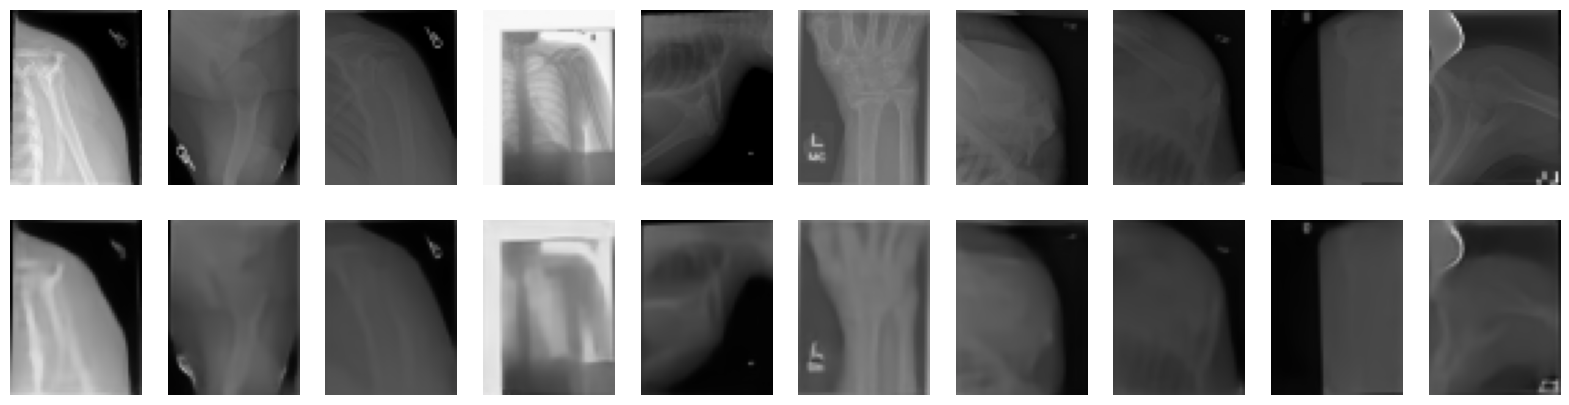

In [ ]:
# plot a few examples
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(np.squeeze(original_images_valid[it]))
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(np.squeeze(original_valid_pred[it]))
    plt.axis('off')
plt.show()